# Fine Tune Test 
Test for fine tuning language models using LoRa on Bath's Hex Cloud

# Setting up on Hex Cloud
## Getting Access
- if you don't have permission to a cluster/machine, email Tom Haines
- open a terminal and sign in via ssh and input your password
    ```
    ssh uniusername@clustername.cs.bath.ac.uk
    ```
    If the following doesn't work, make sure that you're in Bath and if not, connect to the university's VPN or any other VPN

## Access project folders
- once you're in you want to navigate to the the fast/er folders. You want to do all of your projects there because they're the least laggy and you have up to 3.8T of storage for your project (varies)

- <img src="assets/s1.png" width = "300">

- the following is an example of how you would access the fast/faster project files
- check which of the files has the most space and create a folder with your username
- do not put any confidential information or API keys within this folder. If you want to use that, put that in your home folder and call them from your project folder

## Getting Access via VsCode
- open VsCode and in the bottom left corner, you'll get the option to open a remote connection
- then select `Connect Current Window to Host...`
- if the configured ssh you want to use is not there, then select `Add New SSH Host`
    - if you've selected add new host, input `uniusername@clustername.cs.bath.ac.uk`
    - else, select the ssh connection you want
- if you're experiencing issues make sure that you're either in uni or you have a VPN turned on

## Connecting to GitHub
- to clone a repo on a server (using ssh) using GitHub follow the tutorial [here](https://www.theserverside.com/blog/Coffee-Talk-Java-News-Stories-and-Opinions/github-clone-with-ssh-keys)
- remember to save and store all public or private keys within your home directory

## Transferring files
### Using VsCode
- drag files into the working tab directory in VsCode
- probably the best way to quickly transfer files to the Cloud
### Using Github
- this should be straight forward as you can just clone your project in your local directory
### Using CyberDuck (Mac)
- download on the internet, have to pay via app store
- connect via FTAP and there's no need to change the port number

# Setting up ipynb file for Tuning

Once everything is set up on the server or on your own machine, you want to firstly set/assign what GPUs we're going to be using in the cluster. We need to do this first before setting up everything else so it restricts anything from using other GPU's. Check the [usage](https://hex.cs.bath.ac.uk/usage) of the current cluster you're working on and change the GPUs you're using based on that

In [1]:
# important to run this first or else GPU allocation will not work
import os
# set the GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = "6,7"
# setting for vllm inference so that it can run in parallel
os.environ["VLLM_WORKER_MULTIPROC_METHOD"] = "spawn"

In [2]:
# adding all of the neccessary imports
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig, TrainingArguments, pipeline, BitsAndBytesConfig
from huggingface_hub import login, snapshot_download, hf_hub_download
from datasets import load_dataset
from trl import SFTTrainer
import torch
import numpy as np
import math
from tqdm import tqdm
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel
import torch.nn as nn
import pynvml
import matplotlib.pyplot as plt
from accelerate import init_empty_weights, infer_auto_device_map
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import gc
from vllm import LLM, SamplingParams
from typing import List, Optional

In [3]:
# checking if GPU allocation is successful
print(f"Number of available GPUs: {torch.cuda.device_count()}")

Number of available GPUs: 2


In [4]:
# check VRAM
# you will need to alter this code if you're not using the Cheery cluster on Hex
def check_vram():
    # Initialize NVIDIA management library
    pynvml.nvmlInit()

    # Get a handle for each GPU device
    handle_list = [pynvml.nvmlDeviceGetHandleByIndex(i) for i in range(pynvml.nvmlDeviceGetCount())]

    info_used = []
    points = [0,1,2,3,4,5,6,7]
    max_vram = 24

    # Iterate over all GPU devices and print VRAM usage
    for handle in handle_list:
        info = pynvml.nvmlDeviceGetMemoryInfo(handle)
        info_used.append( (info.used//1024**2)/1000)

    print (info_used)

    plt.figure(figsize=(5, 2))
    plt.ylim(0,max_vram)
    plt.bar(points, info_used)
    plt.plot()
    pynvml.nvmlShutdown()

# Downloading the model
For this example we're going to be fine tuning the meta llama-2-7b model that's being downloaded from huggingface. In order to do this though you'll need to go through some preliminary steps

- request access to the llama-2-7b (recommended to get llama-2-7b-hf so you don't have to convert it later) model. This should take about an hour or so depending on when you've sent the request
- create an access key for your huggingface account. Follow this tutorial [here](https://huggingface.co/docs/hub/en/security-tokens) for more info. Make sure that you give the key read and write permissions
- upload your key into a txt file and store it onto the server. As shown in this test it's in the project directory which is not good practice. Store it in your home directory and replace the path
- if you need to convert your model to the huggingface (hf) version, run the `convert_llama_weights_to_hf.py`. This will only work for llama models

If all steps are done then the next code block should work smoothly but will take a while

In [ ]:
"""
DO NOT RUN THIS CODE BLOCK IF 'llama-2-7b-hf' IS IN YOUR DIRECTORY
"""

# getting the authorisation from huggingface
access_key = open('hf_ak.txt','r').read()
login(token = access_key)

# use df -H in the terminal to check and see if there's enough space to download the model
# will save the model in the directory specified
# for future cases it's recommended to download "meta-llama/Llama-2-7b-hf" instead of "meta-llama/Llama-2-7b" as you will not need to convert it later
model_path = snapshot_download("meta-llama/Llama-2-7b-hf", local_dir="./llama-2-7b")

- do not run any of this is if llama-2-7b-hf is filled
- You'll need to convert them to the huggingface Transformers format using the conversion script `convert_llama_weights_to_hf.py`. 
- Obviously, hf stands for huggingface. Maybe with the hf version, the conversion wouldn't be needed
- to run this, run the following

```
python convert_llama_weights_to_hf.py \
    --input_dir /llama-2-7b --model_size 7B --output_dir /llama-2-7b-hf

```

In [ ]:
check_vram()

In [ ]:
# each GPU util
!nvidia-smi --query-gpu=utilization.gpu --format=csv

In [7]:
# Model and tokenizer names
base_model_name = "llama-2-7b-hf"
new_model_name = "llama-2-7b-enhanced" #You can give your own name for fine tuned model

# Tokenizer
llama_tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
llama_tokenizer.pad_token = llama_tokenizer.eos_token
llama_tokenizer.padding_side = "right"

In [ ]:
# Model
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    device_map="auto"
)
base_model.config.use_cache = False
base_model.config.pretraining_tp = 1

In [ ]:
check_vram()

In [ ]:
"""
use the following code if you want to unload the VRAM. You may have to run this more than once to unload
Remove model from GPU. Add any more variables that can get loaded on
"""

# uncomment this if not deleted
# del base_model
# del llama_tokenizer

# Clear any remaining CUDA memory
torch.cuda.empty_cache()
gc.collect()

In [ ]:
# check if your project is still loaded onto the VRAM
print(torch.cuda.memory_allocated())
# this should return 0 if everything is unloaded
print(torch.cuda.memory_reserved())
check_vram()

# Loading the Data

As we're already connected to our huggingface account, you can also download datasets from there too which is what we're doing. This dataset specifically is made for the llama 2 models. 

You need to make sure the data is configured to the data you want. If you want to use data that has no configuration for your chosen model, then reconfigure the data. I will not be doing that in this file but I'll leave a link to example code if I get round to it

In [ ]:
# Data set
# only 1K datapoints but each points has a lot of data
data_name = "mlabonne/guanaco-llama2-1k"
training_data = load_dataset(data_name, split="train")
# check the data
print(training_data.shape)
# #11 is a QA sample in English
print(training_data[11])

# Training

Once you have your model and the data you want to fine tune the model with, we'll start training. In this test, we are going to be using LoRa to make training a language model possible in the first place.

## How LoRa Works:
Full paper [here](https://arxiv.org/abs/2106.09685)

LoRa works by reducing the amount of weight we're fine tuning so that large models can be able to fit onto smaller machines. It does this by using 2 matricies of weights with varying size (rank or r) to represent a hidden layer

For example, if I want to train a single hidden layer with input size 400 and output size 600, then I can reduce that using 2 matrices: a with size `[input, rank]` and b with size `[rank, output]`. Therefore, if I get the dot product of ab, then the size would be `[input, ouput]`. Depending on what you set the rank to be (including other variables). This can significantly reduce the amount of weights that you're fine tuning. Obviously the less weights you're fine tuning, the less effect fine tuning has on the model. This can be good so you don't dramatically alter the pretraining but bad if it's not altering enough.

Once the fine tuning is complete, then you add the fine tuned weights to the weights in the model which will give you your fine tuned model

In [9]:
# Training Params
train_params = TrainingArguments(
    output_dir="./results_modified",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=50,
    logging_steps=50,
    learning_rate=4e-5,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)

In [ ]:
from peft import get_peft_model
# LoRA Config
# reduce rank r if you're running out of vram
peft_parameters = LoraConfig(
    r=4,
    lora_alpha=8,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(base_model, peft_parameters)
model.print_trainable_parameters()

In [ ]:
# Trainer with LoRA configuration
fine_tuning = SFTTrainer(
    model=base_model,
    train_dataset=training_data,
    peft_config=peft_parameters,
    dataset_text_field="text",
    tokenizer=llama_tokenizer,
    args=train_params
)

# Training
fine_tuning.train()

In [12]:
# Save Model
fine_tuning.model.save_pretrained(new_model_name)

In [ ]:
check_vram()

# Merging the model

Since the model that we saved is only the fine tuned weights without the pretrained ones, we need to merge them both together and save it. If llama-2-7b-merged is already in your directory, you will not need to do this step

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
# make sure that both models are available before running or else inference will not work
base_model_name = "llama-2-7b-hf"
new_model_name = "llama-2-7b-enhanced"


base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map="auto"
)

model = PeftModel.from_pretrained(base_model, new_model_name)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [ ]:
output_dir = "llama-2-7b-merged"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

[1.079, 5.791, 0.415, 4.677, 0.415, 0.415, 0.418, 0.418]


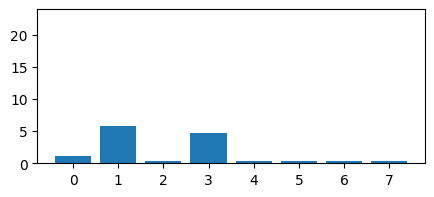

In [5]:
check_vram()

# Inference / Testing 

if the models that you want to test are already saved, then just run the os environment setup,import and nvm check blocks and you can head straight down here


In [6]:
def calculate_perplexity(
    model_path: str,
    tokenizer_path: str,
    texts: List[str],
    max_tokens: Optional[int] = None,
    sliding_window: Optional[int] = None,
) -> float:
    """
    Calculate perplexity using VLLM for efficient inference.
    
    Args:
        model_path: Path to the merged model
        texts: List of texts to evaluate
        max_tokens: Maximum sequence length (optional)
        sliding_window: Size of sliding window for attention (optional)
    
    Returns:
        float: Average perplexity across all texts
    """
    # Initialize VLLM with your model
    llm = LLM(
        model=model_path,
        tensor_parallel_size=2,  # Adjust based on your GPU setup
        max_num_seqs=1,
        tokenizer = tokenizer_path,
        trust_remote_code= True,
    )
    
    # Set sampling parameters for getting logprobs
    sampling_params = SamplingParams(
        temperature=1.0,
        top_p=1.0, 
        max_tokens=1,  # We only need one token for next-token prediction
        logprobs=True # set this to be true if we want to get the perplexity of a model
    )
    
    total_nll = 0.0
    total_tokens = 0
    
    for text in texts:
        # Get logprobs for each position in the sequence
        outputs = llm.generate([text], sampling_params)
        
        for output in outputs:
            # Get the logprobs for each token
            logprobs = output.outputs[0].logprobs[0]
            
            # Sum negative log likelihood
            total_nll += -sum(logprobs)
            total_tokens += len(logprobs)
    

    # print the output of the model. Remove this after it works
    

    # Calculate average negative log likelihood
    avg_nll = total_nll / total_tokens
    
    # Convert to perplexity
    perplexity = np.exp(avg_nll)
    
    return perplexity


In [7]:
# run the perplexity measure
model_path = "llama-2-7b-merged"
tokenizer_path = "llama-2-7b-merged"

# can replace this with test data
test_texts = [
        "This is a sample text to evaluate.",
        "Another example for testing perplexity."
    ]

ppl = calculate_perplexity(
        model_path=model_path,
        tokenizer_path = tokenizer_path,
        texts=test_texts,
        max_tokens=300,  # Adjust based on your model's context window
    )

print("---"*10)
print("\n"*5)    
print(f"Average perplexity: {ppl:.2f}")
print("\n"*5)    
print("---"*10)

INFO 10-22 17:08:51 config.py:905] Defaulting to use mp for distributed inference
INFO 10-22 17:08:51 llm_engine.py:237] Initializing an LLM engine (v0.6.3.post1) with config: model='llama-2-7b-merged', speculative_config=None, tokenizer='llama-2-7b-merged', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=2, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=llama-2-7b-merged, num_scheduler_steps=1, chunked_pr

Loading safetensors checkpoint shards:   0% Completed | 0/3 [00:00<?, ?it/s]


(VllmWorkerProcess pid=3906050) INFO 10-22 17:08:56 model_runner.py:1067] Loading model weights took 6.3096 GB
INFO 10-22 17:08:56 model_runner.py:1067] Loading model weights took 6.3096 GB
INFO 10-22 17:08:57 distributed_gpu_executor.py:57] # GPU blocks: 3698, # CPU blocks: 1024
INFO 10-22 17:08:57 distributed_gpu_executor.py:61] Maximum concurrency for 2048 tokens per request: 28.89x
INFO 10-22 17:08:59 model_runner.py:1395] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
(VllmWorkerProcess pid=3906050) INFO 10-22 17:08:59 model_runner.py:1395] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
(VllmWorkerProcess pid=3906050) INFO 10-22 17:08:59 model_runner.py:1399] CUDA graphs can take 

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s, est. speed input: 41.10 toks/s, output: 4.11 toks/s]

INFO 10-22 17:09:00 multiproc_worker_utils.py:133] Terminating local vLLM worker processes
(VllmWorkerProcess pid=3906050) INFO 10-22 17:09:00 multiproc_worker_utils.py:240] Worker exiting
Average perplexity: 0.00


[rank1]:[W1022 17:09:01.408893378 CudaIPCTypes.cpp:16] Producer process has been terminated before all shared CUDA tensors released. See Note [Sharing CUDA tensors]
